In [8]:
# imports
import numpy as np
import random
import math
import timeit
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [9]:
# Pseudolikelihood calculation
def log_pseudolikelihood(data, h, j, recalculate = True, previous = 0, h_prev=None, j_prev=None, new_row = -1):
    """Sums the rows of the pseudolikelihood"""
    m, n = data.shape
    if recalculate:
        output = 0
        for i in range(n):
            output += log_pseudolikelihood_row(data, h, j, i)
        return -float(output)/m
    else:
        delta = 0
        for r in new_row:
            delta += float(log_pseudolikelihood_row(data, h_prev, j_prev, r) - log_pseudolikelihood_row(data, h, j, r))/m
        return previous + delta
        

def log_pseudolikelihood_row(data, h, j, i):
    """
    Computes the pseudolikelihood for each row
    Assumes j[i,i] = 0 for all i
    """
    m, n = data.shape
    output = 0
    for mu in range(m):
        output += math.log(1 + data[mu, i] * math.tanh(h[i] + np.dot(j[i, :], data[mu, :])))
    return output

In [10]:
# Likelihood calculation
def likelihood(spin_configuration, h, j, partition_function=None):
    if partition_function is None:
        partition_function = partition_function(h, j)
    return math.exp(-hamiltonian(spin_configuration, h, j))/partition_function
    
    
def partition_function(h, j):
    n, = h.shape
    z = 0
    spins = get_all_possible_spin_configurations(n)
    for spin in spins:
        z += math.exp(-hamiltonian(spin, h, j))
    return z

# All hamiltionian functions equivalent up to 1e-12 precision
def hamiltonian(spin_configuration, h, j):
    hamiltonian = 0
    n, = h.shape
    for i in range(n-1):
        hamiltonian += spin_configuration[i] * np.dot(j[i,i+1:], spin_configuration[i+1:])
    hamiltonian += np.dot(h, spin_configuration)
    return -hamiltonian

def hamiltonian_bis(spin_configuration, h, j):
    hamiltonian = 0
    n, = h.shape
    # J is symmetric and J[i,i] = 0
    for i in range(n):
        hamiltonian += spin_configuration[i] * np.dot(j[i,:], spin_configuration)
    hamiltonian /= 2
    hamiltonian += np.dot(h, spin_configuration)
    return -hamiltonian

def hamiltonian_bis2(spin_configuration, h, j):
    # Worst one
    hamiltonian = 0
    n, = h.shape
    for i in range(n):
        for k in range(i+1,n):
            hamiltonian += j[i,k] * spin_configuration[i] * spin_configuration[k]
    hamiltonian += np.dot(h, spin_configuration)
    return -hamiltonian

def get_all_possible_spin_configurations(n):
    # For 10 spins: 10.3 ms ± 109 µs
    # For 16 spins: 768 ms ± 7.81 ms
    return np.array([get_configuration(i,n) for i in range(2**n)])
    
def get_configuration(i, n):
    # 10.4 µs ± 23.5 ns
    binarized = bin(i)[2:]
    spins = np.ones(n, dtype='int') * (-1)
    zeros = np.zeros(n - len(binarized), dtype='int')
    conf = np.array([int(d) for d in str(binarized)])
    bin_conf = np.concatenate((zeros, conf))
    return spins**bin_conf

def get_configuration_bis(i, n):
    # 10.5 µs ± 64.4 ns
    binarized = bin(i)[2:]
    spins = np.ones(n, dtype='int')
    zeros = np.zeros(n - len(binarized), dtype='int')
    conf = np.array([int(d) for d in str(binarized)])
    bin_conf = np.concatenate((zeros, conf))
    spins[bin_conf == 1] = -1
    return spins


In [11]:
# Create random h and J of given dimension
def get_random_h_j(n):
    """
    J will be symmetrical and diagonal zero.
    """
    h = np.random.uniform(-1, 1, size=n)
    j = np.random.uniform(-1, 1, size=(n,n))
    np.fill_diagonal(j, 0)
    j = (j + j.T)/2
    return h, j


def get_random_spin_configuration(n, m=1):
    if m == 1:
        return np.random.randint(0, 1 + 1, size=n)*2 -1
    return np.array([np.random.randint(0, 1 + 1, size=n)*2 -1 for i in range(m)])


def get_spin_configurations_probability(h, j, m):
    start = timeit.default_timer()
    # return array of spins with probability given by h and j
    n, = h.shape
    z = partition_function(h, j)
    possible = get_all_possible_spin_configurations(n)
    possible_int = np.arange(2**n)
    prob = np.array([likelihood(spin, h, j, partition_function=z) for spin in possible])
    dataset = np.random.choice(possible_int, size=m, p=prob)
    print(timeit.default_timer() - start)
    return np.array([get_configuration(i, n) for i in dataset])

def symmetrize(j):
    return (j + j.T)/2
    

In [12]:
def energy(temp, func, func_new):
    return math.exp(-(func_new - func) / temp)


def neighbour_uniform(s, delta=0.5):
    lower = max(s - delta, -1.)
    upper = min(s + delta, 1.)
    return np.random.uniform(lower, upper)


def random_change_h_j(h, j, delta=0.5):
    h_new = np.copy(h)
    j_new = np.copy(j)
    n, = h_new.shape
    row = np.random.randint(0, n + 1)
    column = np.random.randint(0, n)
    while row == column:
        row = np.random.randint(0, n + 1)
        column = np.random.randint(0, n)
    if row == n:
        h_new[column] = neighbour_uniform(h_new[column], delta)
    else:
        j_new[row, column] = neighbour_uniform(j_new[row, column], delta)
    return h_new, j_new

def random_change_h_j_row(h, j, delta=0.5):
    h_new = np.copy(h)
    j_new = np.copy(j)
    n, = h_new.shape
    if random.random() < 2./(n + 1):
        # h must be changed (n over n + n(n-1)/2)
        column = np.random.randint(0, n)
        h_new[column] = neighbour_uniform(h_new[column], delta)
        return h_new, j_new, (column,)
    else:
        # j must be changed
        row = np.random.randint(0, n)
        column = np.random.randint(0, n)
        while row == column:
            row = np.random.randint(0, n)
            column = np.random.randint(0, n)
        j_new[row, column] = neighbour_uniform(j_new[row, column], delta)
        j_new[column, row] = j_new[row, column]
        return h_new, j_new, (row, column)        
    
def mean_error(h, j, hp, jp):
    n, = h.shape
    numerator = np.linalg.norm(flat_sym_matrix(j) - flat_sym_matrix(jp))**2 + np.linalg.norm(h-hp)**2
    denominator = np.linalg.norm(flat_sym_matrix(jp))**2 + np.linalg.norm(hp)**2
    return np.sqrt(numerator/denominator)

In [13]:
def flat_sym_matrix(a):
    return a[np.triu_indices_from(a, k=1)]


In [21]:
# Simulated annealing

def simulated_algorithm_min_multi(data, h0, j0, values=None, mc_steps=800, temp_ini=3):
    start = timeit.default_timer()
    m, n = data.shape
    if values is None:
        h1, j1 = get_random_h_j(n)
    else:
        h1, j1 = values
    h_iter, j_iter = h1, j1
    h_min, j_min = h1, j1
    func_iter = log_pseudolikelihood(data, h_iter, j_iter)
    func_min = func_iter
    rec = False
    error = []
    min_vals = []
    max_num_iters = int((n*(n+1)/2)*mc_steps)
    for k in tqdm_notebook(range(max_num_iters)):
        if k%100 == 0:
            plot_values(h_iter, j_iter, h0, j0, int(k/100))
        if k%200 == 0:
            rec = True
        error.append(mean_error(h_iter, j_iter, h0, j0))
        min_vals.append(func_iter)
        temp = temp_ini * (1. - float(k) / (max_num_iters))
        h_new, j_new, row = random_change_h_j_row(h_iter, j_iter, delta=0.3)
        func_new = log_pseudolikelihood(data, h_new, j_new, recalculate=rec, previous=func_iter, h_prev=h_iter, j_prev=j_iter, new_row=row)
        rec = False
        if func_new < func_iter:
            h_iter, j_iter = h_new, j_new
            func_iter = func_new
            if func_new < func_min:
                h_min, j_min = h_new, j_new
                func_min = func_new
        elif random.random() < energy(temp, func_iter, func_new):
            h_iter, j_iter = h_new, j_new
            func_iter = func_new
    #print(h_iter, j_iter, func_iter)
    #print(h_min, j_min, func_min)
    output_value = find_local_minimum_multi(data, h_min, j_min, func_min, initial_delta=0.3, max_iter=int(max_num_iters/10))
    print('MC simulated annealing time:', timeit.default_timer() - start)
    return output_value, error, min_vals


def find_local_minimum_multi(data, h_ini, j_ini, func_ini, max_iter=1000, initial_delta=0.5):
    h_min, j_min = h_ini, j_ini
    func_min = func_ini
    for k in tqdm_notebook(range(max_iter)):
        delta = initial_delta * (max_iter - k) / max_iter
        h_new, j_new, row = random_change_h_j_row(h_min, j_min, delta=delta)
        func_new = log_pseudolikelihood(data, h_new, j_new, recalculate=False, previous=func_min, h_prev=h_min, j_prev=j_min, new_row=row)
        if func_new < func_min:
            h_min, j_min = h_new, j_new
            func_min = func_new
    return h_min, j_min, func_min

In [22]:
def write_arr_to_file(filename, arr1, arr2):
    f = open(filename, "w+")
    for e1, e2 in zip(arr1, arr2):
        f.write(str(e1)+' '+str(e2)+"\n")
    f.close()
def read_arr_from_file(filename):
    arr1 = []
    arr2 = []
    with open(filename, 'r') as fp:
        s = fp.readlines()
    for e in s:
        arr1.append(e.split()[0])
        arr2.append(e.split()[1])

    return np.array(arr1, dtype='float'), np.array(arr2, dtype='float')

In [23]:
from matplotlib import rc
import matplotlib
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [24]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
def plot_values(h, j, h0, j0, num):
    n, = h.shape
    size = 100
    plt.figure(figsize = (10, 10))
    ax = plt.axes()
    plt.title('Iteration' + str(num*100))
    plt.xlabel(r'$h^{0}_i$', rotation=0, fontsize=45)
    plt.ylabel(r'$\Delta h_i$', rotation=0, fontsize=45)
    ax.xaxis.set_label_coords(0.5, -0.1)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    plt.plot((-1, 1), (0,0), color='#55ff00', label='y=x', zorder=1, linewidth=1, alpha=1)
    plt.scatter(h0, h-h0, color='#ee2222', label='N=4', zorder=6, marker="o", s=size)

    plt.ylim(-2, 2)
    plt.xlim(-1, 1)

    # Make a plot with major ticks that are multiples of 20 and minor ticks that
    # are multiples of 5.  Label major ticks with '%d' formatting but don't label
    # minor ticks.
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    # For the minor ticks, use no labels; default NullFormatter.
    ax.xaxis.set_minor_locator(MultipleLocator(0.2))
    # Make a plot with major ticks that are multiples of 20 and minor ticks that
    # are multiples of 5.  Label major ticks with '%d' formatting but don't label
    # minor ticks.
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    # For the minor ticks, use no labels; default NullFormatter.
    ax.yaxis.set_minor_locator(MultipleLocator(0.2))
    plt.xticks(fontsize=35)
    plt.yticks(fontsize=35)
    ax.tick_params(which='both', width=4)
    ax.tick_params(which='major', length=12)
    ax.tick_params(which='minor', length=7)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(4)
    #plt.grid()
    #plt.legend()
    filename = 'test/field/h_n_' + str(n) + '_iter_' + str(num) + '.png'
    plt.savefig(filename, bbox_inches = 'tight')
    plt.close()
    
    plt.figure(figsize = (10, 10))
    ax = plt.axes()
    plt.title('Iteration' + str(num*100))
    plt.xlabel(r'$J^{0}_{ij}$', rotation=0, fontsize=45)
    plt.ylabel(r'$\Delta J_{ij}$', rotation=0, fontsize=45)
    ax.xaxis.set_label_coords(0.5, -0.1)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    plt.plot((-1, 1), (0,0), color='#55ff00', label='y=x', zorder=1, linewidth=1, alpha=1)
    plt.scatter(j0, j-j0, color='#ee2222', label='N=4', zorder=6, marker="o", s=size)

    plt.ylim(-2, 2)
    plt.xlim(-1, 1)

    # Make a plot with major ticks that are multiples of 20 and minor ticks that
    # are multiples of 5.  Label major ticks with '%d' formatting but don't label
    # minor ticks.
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    # For the minor ticks, use no labels; default NullFormatter.
    ax.xaxis.set_minor_locator(MultipleLocator(0.2))
    # Make a plot with major ticks that are multiples of 20 and minor ticks that
    # are multiples of 5.  Label major ticks with '%d' formatting but don't label
    # minor ticks.
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    # For the minor ticks, use no labels; default NullFormatter.
    ax.yaxis.set_minor_locator(MultipleLocator(0.2))
    plt.xticks(fontsize=35)
    plt.yticks(fontsize=35)
    ax.tick_params(which='both', width=4)
    ax.tick_params(which='major', length=12)
    ax.tick_params(which='minor', length=7)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(4)
    #plt.grid()
    #plt.legend()
    filename = 'test/couplings/j_n_' + str(n) + '_iter_' + str(num) + '.png'
    plt.savefig(filename, bbox_inches = 'tight')
    plt.close()


In [ ]:
X = 500
m = 15000
print('N=4')
n = 4
h4, j4 = get_random_h_j(n)
spins = get_spin_configurations_probability(h4, j4, m)
result4 = simulated_algorithm_min_multi(spins, h4, j4, mc_steps=X)[0]
write_arr_to_file('h4_m15_x500.txt', h4, result4[0])
write_arr_to_file('j4_m15_x500.txt', flat_sym_matrix(j4), flat_sym_matrix(result4[1]))

N=4
0.002159743999982311


In [34]:
start = timeit.default_timer()
X = 500
m = 15000
print('N=4')
n = 4
h4, j4 = get_random_h_j(n)
spins = get_spin_configurations_probability(h4, j4, m)
result4 = simulated_algorithm_min_multi(spins, h4, j4, mc_steps=X)[0]
write_arr_to_file('h4_m15_x500.txt', h4, result4[0])
write_arr_to_file('j4_m15_x500.txt', flat_sym_matrix(j4), flat_sym_matrix(result4[1]))


print('N=8')
n = 8
h8, j8 = get_random_h_j(n)
spins = get_spin_configurations_probability(h8, j8, m)
result8 = simulated_algorithm_min_multi(spins, h8, j8, mc_steps=X)[0]
write_arr_to_file('h8_m15_x500.txt', h8, result8[0])
write_arr_to_file('j8_m15_x500.txt', flat_sym_matrix(j8), flat_sym_matrix(result8[1]))


print('N=12')
n = 12
h12, j12 = get_random_h_j(n)
spins = get_spin_configurations_probability(h12, j12, m)
result12 = simulated_algorithm_min_multi(spins, h12, j12, mc_steps=X)[0]
write_arr_to_file('h12_m15_x500.txt', h12, result12[0])
write_arr_to_file('j12_m15_x500.txt', flat_sym_matrix(j12), flat_sym_matrix(result12[1]))


print('N=16')
n = 16
h16, j16 = get_random_h_j(n)
spins = get_spin_configurations_probability(h16, j16, m)
result16 = simulated_algorithm_min_multi(spins, h16, j16, mc_steps=X)[0]
write_arr_to_file('h16_m15_x500.txt', h16, result16[0])
write_arr_to_file('j16_m15_x500.txt', flat_sym_matrix(j16), flat_sym_matrix(result16[1]))
"""
print('N=20')
n = 20
h20, j20 = get_random_h_j(n)
spins = get_spin_configurations_probability(h20, j20, m)
result20 = simulated_algorithm_min_multi(spins, mc_steps=X)[0]
"""
print(timeit.default_timer() - start)

N=4
0.002100221000091551



MC simulated annealing time: 1204.418205886
N=8
0.027793181000106415



MC simulated annealing time: 4866.857049479
N=12
0.4406461720000152



MC simulated annealing time: 11043.595320336
N=16
8.974421111997799



MC simulated annealing time: 19989.655756093005
37114.665498574


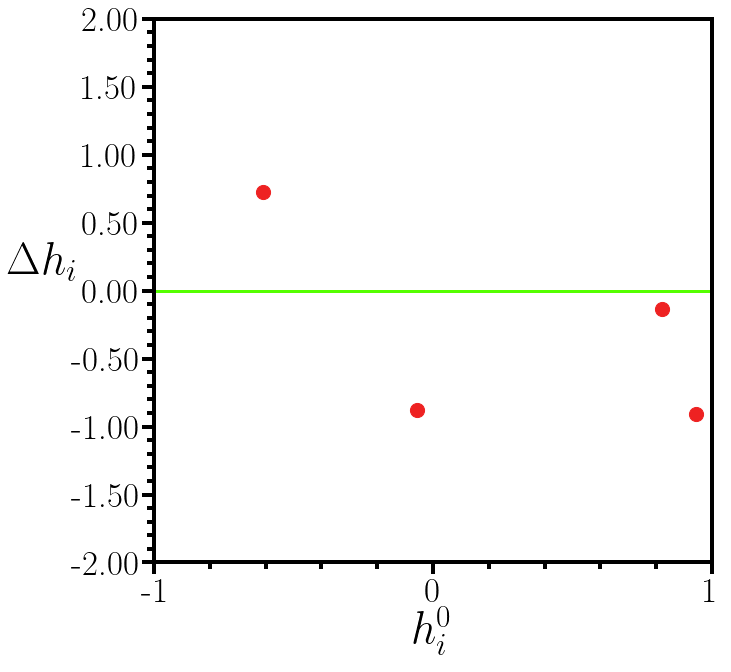

0.9076319152073155


In [20]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
size = 200
plt.figure(figsize = (10, 10))
ax = plt.axes()
#plt.title('Predicted field vs original field')
plt.xlabel(r'$h^{0}_i$', rotation=0, fontsize=45)
plt.ylabel(r'$\Delta h_i$', rotation=0, fontsize=45)
ax.xaxis.set_label_coords(0.5, -0.1)
ax.yaxis.set_label_coords(-0.2, 0.5)
plt.plot((-1, 1), (0,0), color='#55ff00', label='y=x', zorder=1, linewidth=3, alpha=1)
plt.scatter(h4, result4[0]-h4, color='#ee2222', label='N=4', zorder=6, marker="o", s=size)
#plt.scatter(h8, result8[0]-h8, color='#00bb00', label='N=8', zorder=5, marker="v", s=size)
#plt.scatter(h12, result12[0]-h12, color='#0000ee', label='N=12', zorder=4, marker="^", s=size)
#plt.scatter(h16, result16[0]-h16, color='#E8B201', label='N=16', zorder=3, marker="s", s=size)
#plt.scatter(h20, result20[0], color='#B300FF', label='N=20', zorder=2, marker="D")

plt.ylim(-2, 2)
plt.xlim(-1, 1)

# Make a plot with major ticks that are multiples of 20 and minor ticks that
# are multiples of 5.  Label major ticks with '%d' formatting but don't label
# minor ticks.
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
# Make a plot with major ticks that are multiples of 20 and minor ticks that
# are multiples of 5.  Label major ticks with '%d' formatting but don't label
# minor ticks.
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# For the minor ticks, use no labels; default NullFormatter.
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
ax.tick_params(which='both', width=4)
ax.tick_params(which='major', length=12)
ax.tick_params(which='minor', length=7)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(4)
#plt.grid()
#plt.legend()
plt.savefig('field4.png', bbox_inches = 'tight')
plt.show()
print(max(abs(result4[0]-h4)))
#print(max(abs(result8[0]-h8)))
#print(max(abs(result12[0]-h12)))
#print(max(abs(result16[0]-h16)))

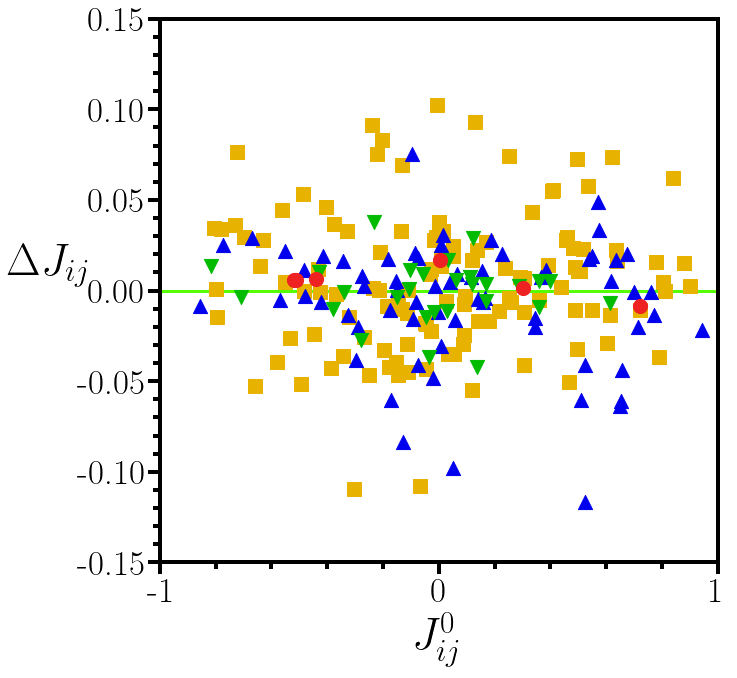

0.016610751903778694
0.04244303510628086
0.11655130817569126
0.10955340271821018


In [55]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
plt.figure(figsize = (10, 10))
ax = plt.axes()
#plt.title('Predicted couplings vs original couplings')
plt.xlabel(r'$J^{0}_{ij}$', rotation=0, fontsize=45)
plt.ylabel(r'$\Delta J_{ij}$', rotation=0, fontsize=45)
ax.xaxis.set_label_coords(0.5, -0.1)
ax.yaxis.set_label_coords(-0.2, 0.5)
plt.plot((-1, 1), (0,0), color='#55ff00', label='y=x', zorder=1, linewidth=3, alpha=1)
plt.scatter(flat_sym_matrix(j4), flat_sym_matrix(result4[1]-j4), color='#ee2222', label='N=4', zorder=6, marker="o", s=size)
plt.scatter(flat_sym_matrix(j8), flat_sym_matrix(result8[1]-j8), color='#00bb00', label='N=8', zorder=5, marker="v", s=size)
plt.scatter(flat_sym_matrix(j12), flat_sym_matrix(result12[1]-j12), color='#0000ee', label='N=12', zorder=4, marker="^", s=size)
plt.scatter(flat_sym_matrix(j16), flat_sym_matrix(result16[1]-j16), color='#E8B201', label='N=16', zorder=3, marker="s", s=size)
#plt.scatter(flat_sym_matrix(j20), flat_sym_matrix(result20[1]), color='#B300FF', label='N=20', zorder=2, marker="D")

plt.ylim(-0.15, 0.15)
plt.xlim(-1, 1)

# Make a plot with major ticks that are multiples of 20 and minor ticks that
# are multiples of 5.  Label major ticks with '%d' formatting but don't label
# minor ticks.
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
# Make a plot with major ticks that are multiples of 20 and minor ticks that
# are multiples of 5.  Label major ticks with '%d' formatting but don't label
# minor ticks.
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# For the minor ticks, use no labels; default NullFormatter.
ax.yaxis.set_minor_locator(MultipleLocator(0.01))
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
ax.tick_params(which='both', width=4)
ax.tick_params(which='major', length=12)
ax.tick_params(which='minor', length=7)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(4)
#plt.grid()
#plt.legend()
plt.savefig('couplings4.png', bbox_inches = 'tight')
plt.show()
print(max(abs(flat_sym_matrix(result4[1]-j4))))
print(max(abs(flat_sym_matrix(result8[1]-j8))))
print(max(abs(flat_sym_matrix(result12[1]-j12))))
print(max(abs(flat_sym_matrix(result16[1]-j16))))

In [56]:
print(h4)
print(result4[0])
print(j4)
print(result4[1])
print(mean_error(h4, j4, result4[0], result4[1]))
print(mean_error(h8, j8, result8[0], result8[1]))
print(mean_error(h12, j12, result12[0], result12[1]))
print(mean_error(h16, j16, result16[0], result16[1]))

[ 0.2971927   0.14751929  0.79334061 -0.40405221]
[ 0.29780734  0.13441879  0.77304393 -0.40954403]
[[ 0.          0.30230249 -0.5198877  -0.43872728]
 [ 0.30230249  0.          0.00503553  0.7224527 ]
 [-0.5198877   0.00503553  0.         -0.51178804]
 [-0.43872728  0.7224527  -0.51178804  0.        ]]
[[ 0.          0.30357192 -0.51425523 -0.4324663 ]
 [ 0.30357192  0.          0.02164629  0.7140071 ]
 [-0.51425523  0.02164629  0.         -0.50606336]
 [-0.4324663   0.7140071  -0.50606336  0.        ]]
0.02210945234726514
0.0539710695806426
0.08538837702902843
0.08283907807258636


In [57]:
from skimage import io, exposure, color, img_as_float, img_as_int, img_as_uint, img_as_ubyte
image1 = io.imread('field4.png')
image2 = io.imread('couplings4.png')
print(image1.shape)
print(image2.shape)
def two_images(img1, img2, savename):
    io.imsave(savename, np.hstack((img1, img2)))
two_images(image1, image2, 'h_j_joined4.png')

(678, 737, 4)
(678, 737, 4)
